In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

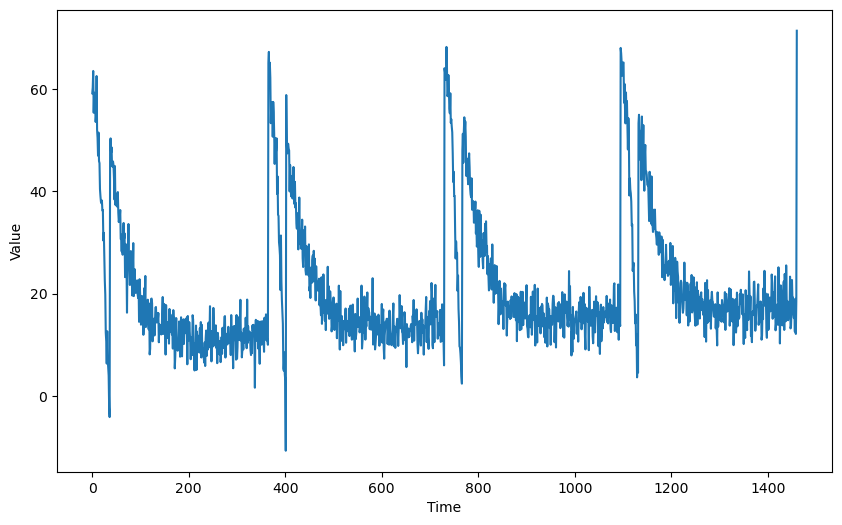

In [7]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [8]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [10]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):

    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    

    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [11]:
print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

NameError: name 'batch_of_features' is not defined